### Set up water network model

In this example, we test the VQLS quantum solver with a noisy simulator. Let's start by setting up the model:

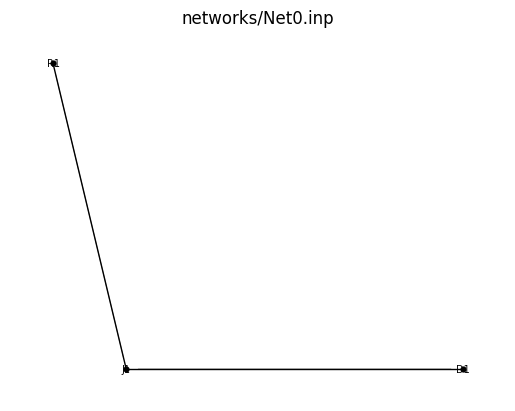

<Axes: title={'center': 'networks/Net0.inp'}>

In [1]:
import os
import wntr
import wntr_quantum

os.environ["EPANET_TMP"] = "/Users/murilo/scratch_dir/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = 'networks/Net0.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [2]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

# load EPANET A and b matrices from temp
epanet_A, epanet_b = wntr_quantum.sim.epanet.load_epanet_matrix()

# check the size of the A and b matrices
epanet_A_dim = epanet_A.todense().shape[0]
epanet_b_dim = epanet_b.shape[0]
print(f"* Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"* Size of the b vector in EPANET simulator: {epanet_b_dim}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/.epanet_quantum

* Size of the Jacobian in EPANET simulator: 2
* Size of the b vector in EPANET simulator: 2


(name         J1         D1            R1
 0     29.647690  19.167675 -9.338379e-07
 3600  29.647692  19.167675 -9.338379e-07,
 name    P1    P2
 0     0.05  0.05
 3600  0.05  0.05)

### Define helper functions

Before proceeding to the proper quantum solution of the water network model, let's define some helper functions. These will calculate the absolute percentage error (APE) between classical and quantum results, checking also that they are within a certain tolerance `TOL`%.

In [3]:
TOL = 50  # => per cent
DELTA = 1.0e-12


def get_ape_from_pd_series(quantum_pd_series, classical_pd_series):
    """Helper function to evaluate absolute percentage error between classical and quantum results."""
    ape = abs(quantum_pd_series - classical_pd_series) * 100.0 / abs(classical_pd_series + DELTA)
    return ape


def compare_results(classical_result, quantum_result):
    """
    Helper function that compares the classical and quantum simulation results.
    """
    classical_data = []
    quantum_data = []

    def check_ape(classical_value, quantum_value):
        """Helper function to check if the absolute percentage error between classical and quantum results is within TOL."""
        ape = abs(quantum_value - classical_value) * 100.0 / abs(classical_value + DELTA)
        is_close_to_classical = ape <= TOL
        if is_close_to_classical:
            print(f"Quantum result {quantum_value} within {ape}% of classical result {classical_value}")
            quantum_data.append(quantum_value)
            classical_data.append(classical_value)
        return is_close_to_classical

    for link in classical_result.link["flowrate"].columns:
        classical_value = classical_result.link["flowrate"][link].iloc[0]
        quantum_value = quantum_result.link["flowrate"][link].iloc[0]
        message = f"Flowrate {link}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert check_ape(classical_value, quantum_value), message

    for node in classical_result.node["pressure"].columns:
        classical_value = classical_result.node["pressure"][node].iloc[0]
        quantum_value = quantum_result.node["pressure"][node].iloc[0]
        message = f"Pressure {node}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert check_ape(classical_value, quantum_value), message

    return classical_data, quantum_data

### Solve water network with `QuantumEpanetSimulator` and VQLS 

We now solve the model using VQLS and a noisy model.

In [4]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as qiskit_aer_EstimatorV2
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

# create a noise model from a backend
# the model could have been created from a real hardware
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService()
# real_hardware = service.backend("ibm_kyoto")
noise_model = NoiseModel.from_backend(FakeManilaV2())

# noise_model = NoiseModel()
# cx_depolarizing_prob = 0.001  # => add later a 0.1% on every two-qubit CNOT gate
# noise_model.add_all_qubit_quantum_error(
#     depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
# )

# set up quantum backend and estimator
backend = AerSimulator()
estimator = qiskit_aer_EstimatorV2(
    options=dict(
        backend_options=dict(noise_model=noise_model),
        run_options=dict(shots=4000, seed=42)
    )
)

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="symmetric",
    verbose=True,
    preconditioner="diagonal_scaling",
    reorder=True,
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_vqls = sim.run_sim(linear_solver=linear_solver)

results_classical, results_quantum = compare_results(results_epanet, results_vqls)

results_vqls.node["pressure"], results_vqls.link["flowrate"]

VQLS Iteration 1000 Cost 2.745e-01
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 2.744669E-01    MAXCV = 0.000000E+00
   X =-2.616350E-01   1.867206E+00  -1.480330E+00   2.694037E+00
Optimization terminated successfully.
         Current function value: 0.269942
         Iterations: 30
         Function evaluations: 445
         Gradient evaluations: 89
VQLS Iteration 1000 Cost 2.740e-01
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 2.739724E-01    MAXCV = 0.000000E+00
   X = 1.399187E+00  -4.260211E-01  -1.409586E+00  -2.943989E+00
Optimization terminated successfully.
         Current function value: 0.268906
         Iterations: 42
         Function evaluations: 575
         Gradient evaluations: 115
VQLS Iteration 1000 Cost 2.707e-01
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 2.706916E-01    MAXCV = 0.000000E+00
   X =-

(name         J1         D1            R1
 0     29.542120  15.944172 -9.338379e-07
 3600  29.556778  16.391262 -9.338379e-07,
 name        P1        P2
 0     0.057535  0.057435
 3600  0.056492  0.056409)

### Plot Network model with absolute percent errors

To compare the results, we plot the network together with the absolute percent errors (with respect to the classical results) for the predicted pressures and flow rates.

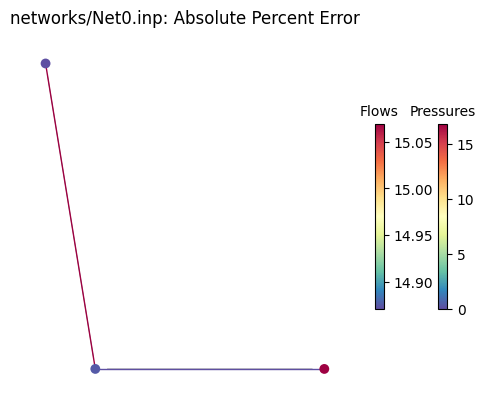

<Axes: title={'center': 'networks/Net0.inp: Absolute Percent Error'}>

In [6]:

wntr.graphics.plot_network(
    wn,
    node_attribute=get_ape_from_pd_series(
        results_vqls.node["pressure"].iloc[0],
        results_epanet.node["pressure"].iloc[0]
    ),
    link_attribute=get_ape_from_pd_series(
        results_vqls.link["flowrate"].iloc[0],
        results_epanet.link["flowrate"].iloc[0],
    ),
    node_colorbar_label='Pressures',
    link_colorbar_label='Flows',
    node_size=50,
    title=f"{inp_file}: Absolute Percent Error",
    node_labels=False
)

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

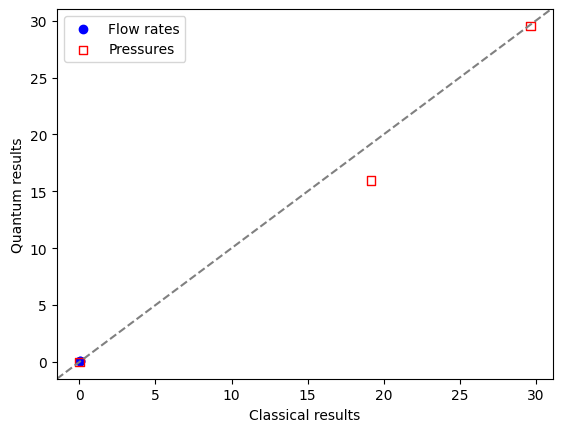

([0.05000009, 0.05, 29.64769, 19.167675, -9.338379e-07],
 [0.0575348, 0.057435457, 29.54212, 15.944172, -9.338379e-07])

In [7]:
import matplotlib.pyplot as plt
plt.scatter(results_classical[:n_pipes], results_quantum[:n_pipes], label="Flow rates", color="blue", marker="o")
plt.scatter(results_classical[n_pipes:], results_quantum[n_pipes:], label="Pressures", color="red", marker="s", facecolors='none')
plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
plt.xlabel("Classical results")
plt.ylabel("Quantum results")
plt.legend()
plt.show()

results_classical, results_quantum